# Use of `shrecc`

This notebook guides you through the various steps needed to create spatially- and regionally-specific consumption electricity mixes. These mixes are written directly in a dedicated `brightway` database, ready to be used in your own LCA project.

In [1]:
import os
import sys

# Get the directory of the notebook
notebook_dir = os.getcwd()

# Assuming the SHRECC directory is the parent of the current directory
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add the project root to the Python path
sys.path.append(project_root)

In [2]:
import bw2data as bd
import bw2io as bi
import pandas as pd

from shrecc.download import get_data, download_shrecc_data
from shrecc.treatment import data_processing
from shrecc.database import create_database, filt_cutoff

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

11:22:25 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


## Prepare your data

Do this in case you want to download data for any other year than the default year in the `shrecc_data` [repository](https://git.list.lu/shrecc_project/shrecc_data), or if you simply want to recalculate it on your own.

First, run function get_data(). This will download all the electricity data for all countries for a selected year.

In [3]:
data = get_data(year=2022,
                root=project_root)
#if no root given, the function wil$l try to find SHRECC package in your installed environment

API data loaded successfully.


Next, it's time to treat the data. This part is very heavy due to matrix inversion, and is recommended to run on a server.

In [4]:
data_processing(data_df=data,
                year=2022,
                root=project_root)
#if no root given, the function will try to find SHRECC package in your installed environment


Processing data...


g:\Nextcloud\shrecc_project\shrecc\shrecc\treatment.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col in data_df.T.index


saving pickles
pickles saved
treating data
Calculating consumption losses
Results loaded from cons_results_2022.pkl
Calculating consumption losses finished
Applying load losses
Load losses applied and saved
Light results loaded
..all done!


And that's literally it! Now it's time to select which countries and times you are interested in and create your database.

## Get your project ready
In order to run following functions, you need to have a `brightway` (2 or 2.5) project with biosphere and ecoinvent installed. Matching of electricity sources is valid for ecoinvent 3.9.1, but should be compatible with 3.10 and 3.11. You also need to have a `pandas` dataframe with all the electricity data. Either you created it on your own with the above steps, or you downloaded it from [our git](https://git.list.lu/shrecc_project/shrecc_data).

In [5]:
bd.projects.set_current('SHRECCbw25')

In [6]:
bd.databases

Databases dictionary with 6 object(s):
	ecoinvent-3.9.1-biosphere
	ecoinvent-3.9.1-cutoff
	elec_february_2021_evening
	elec_february_2022_evening
	elec_june_2021_noon
	elec_june_2022_noon

In [7]:
if 'ecoinvent-3.9.1-cutoff' not in bd.databases:

    bi.import_ecoinvent_release(
        version="3.9.1",
        system_model="cutoff",
        username=os.environ["ECOINVENT_LOG"],
        password=os.environ["ECOINVENT_PASS"],
    )

To download already-calculated data, you can visit the SHRECC data git repository: https://git.list.lu/shrecc_project/shrecc_data

### Example 1: all days in June around noon
In this example, we model the consumption mix of five countries, around noon on all days in June.


In [8]:
countries = ["FI", "SE", "LU", "AT", "FR"]

In [11]:
example = filt_cutoff(
    countries=countries,
    general_range=["2022-06-01 01:00:00",
                   "2022-06-30 23:00:00"],
    refined_range=[10, 14],
    freq="h",
    cutoff=1e-3,
    include_cutoff=True,
    root="..",
)

Mapping technologies...
Technologies mapped.
Filtering dataframe...
Dataframe filtered.


#### To create a database based on our filtered and cut off dataframe with selected days/times

In [12]:
example.head()

country                                                                                                       AT  \
geography_source activityName                                       product                   unitName             
AT               electricity production, deep geothermal            electricity, high voltage kWh       0.000000   
                 electricity production, hard coal                  electricity, high voltage kWh       0.000000   
                 electricity production, hydro, pumped storage      electricity, high voltage kWh       0.030967   
                 electricity production, hydro, reservoir, alpin... electricity, high voltage kWh       0.068467   
                 electricity production, hydro, run-of-river        electricity, high voltage kWh       0.444558   

country                                                                                                  FI  \
geography_source activityName                                       product                   unitName        
AT               electricity production, deep geothermal            electricity, high voltage kWh       0.0   
                 electricity production, hard coal                  electricity, high voltage kWh       0.0   
                 electricity production, hydro, pumped storage      electricity, high voltage kWh       0.0   
                 electricity production, hydro, reservoir, alpin... electricity, high voltage kWh       0.0   
                 electricity production, hydro, run-of-river        electricity, high voltage kWh       0.0   

country                                                                                                  FR  \
geography_source activityName                                       product                   unitName        
AT               electricity production, deep geothermal            electricity, high voltage kWh       0.0   
                 electricity production, hard coal                  electricity, high voltage kWh       0.0   
                 electricity production, hydro, pumped storage      electricity, high voltage kWh       0.0   
                 electricity production, hydro, reservoir, alpin... electricity, high voltage kWh       0.0   
                 electricity production, hydro, run-of-river        electricity, high voltage kWh       0.0   

country                                                                                                  LU  \
geography_source activityName                                       product                   unitName        
AT               electricity production, deep geothermal            electricity, high voltage kWh       0.0   
                 electricity production, hard coal                  electricity, high voltage kWh       0.0   
                 electricity production, hydro, pumped storage      electricity, high voltage kWh       0.0   
                 electricity production, hydro, reservoir, alpin... electricity, high voltage kWh       0.0   
                 electricity production, hydro, run-of-river        electricity, high voltage kWh       0.0   

country                                                                                                  SE  
geography_source activityName                                       product                   unitName       
AT               electricity production, deep geothermal            electricity, high voltage kWh       0.0  
                 electricity production, hard coal                  electricity, high voltage kWh       0.0  
                 electricity production, hydro, pumped storage      electricity, high voltage kWh       0.0  
                 electricity production, hydro, reservoir, alpin... electricity, high voltage kWh       0.0  
                 electricity production, hydro, run-of-river        electricity, high voltage kWh       0.0

In [14]:
create_database(dataframe_filt = example,
                project_name   = "SHRECCbw25",
                db_name        = "elec_june_2022_noon",
                eidb_name      = "ecoinvent-3.9.1-cutoff")

100%|██████████| 5/5 [00:00<00:00, 157.94it/s]


14:57:00 [info     ] Vacuuming database            


#### Another example of dataframe, this time on February evenings

In [ ]:
example2 = filt_cutoff(
    countries=countries,
    general_range=["2022-02-01 01:00:00", "2022-02-28 23:00:00"], 
    refined_range=[19, 23],
    freq="h",
    cutoff=1e-3,
    include_cutoff=True,
    root="..",
)

Mapping technologies...
Technologies mapped.
Filtering dataframe...
Dataframe filtered.


In [ ]:
create_database(dataframe_filt = example2,
                project_name   = "SHRECCbw25",
                db_name        = "elec_february_2022_evening",
                eidb_name      = "ei391")

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 468.52it/s]


Vacuuming database 


# Test
We run an LCA for the 4 mix samples, as well as their ecoinvent 3.9.1 equivalents.

In [ ]:
import bw2calc as bc

In [ ]:
ef_methods = [m for m in bd.methods if 'EF v3.0' == m[0]]
config = {"impact_categories" : ef_methods}

In [ ]:
demands_summer_noon    = {f"{a['name']}, summer, noon":{a['id']:1} for a in bd.Database('elec_june_2022_noon')}
demands_winter_evening = {f"{a['name']}, winter, evening":{a['id']:1} for a in bd.Database('elec_february_2022_evening')}
demands = {**demands_summer_noon, **demands_winter_evening}

In [ ]:
acts_ei = [bd.get_node(database='ei391',
                       location=country,
                       name='market for electricity, low voltage') for country in sorted(countries)]
acts_ei

['market for electricity, low voltage' (kilowatt hour, AT, None),
 'market for electricity, low voltage' (kilowatt hour, FI, None),
 'market for electricity, low voltage' (kilowatt hour, FR, None),
 'market for electricity, low voltage' (kilowatt hour, LU, None),
 'market for electricity, low voltage' (kilowatt hour, SE, None)]

In [ ]:
demands.update({f"{a['name']}, {a['location']}":{a['id']:1} for a in acts_ei})
demands

{'Electricity mix in AT, summer, noon': {31765: 1},
 'Electricity mix in FI, summer, noon': {31766: 1},
 'Electricity mix in SE, summer, noon': {31769: 1},
 'Electricity mix in LU, summer, noon': {31768: 1},
 'Electricity mix in FR, summer, noon': {31767: 1},
 'Electricity mix in AT, winter, evening': {31770: 1},
 'Electricity mix in LU, winter, evening': {31773: 1},
 'Electricity mix in SE, winter, evening': {31774: 1},
 'Electricity mix in FI, winter, evening': {31771: 1},
 'Electricity mix in FR, winter, evening': {31772: 1},
 'market for electricity, low voltage, AT': {8291: 1},
 'market for electricity, low voltage, FI': {7811: 1},
 'market for electricity, low voltage, FR': {8312: 1},
 'market for electricity, low voltage, LU': {18072: 1},
 'market for electricity, low voltage, SE': {22321: 1}}

In [ ]:
data_objs = bd.get_multilca_data_objs(functional_units=demands,
                                      method_config=config)

In [ ]:
m_lca = bc.MultiLCA(demands=demands,
                    method_config=config,
                    data_objs=data_objs)

In [ ]:
m_lca.lci()

In [ ]:
m_lca.lcia()

In [ ]:
results = []
for (method, fu), score in m_lca.scores.items():    
    demand = m_lca.demands[fu]
    a_id = list(demand).pop()
    a = bd.get_activity(a_id)    
    # prod_e = list(a.production()).pop()    
    results.append(
            {
                "activity": a['name'],
                "database": a['database'],
                "location": a['location'],
                "production amount": demand[a_id],
                "activity unit": a["unit"],
                "reference product": a["reference product"],
                "methodology": method[0],
                "category": method[1],
                "indicator": method[2],
                "score": score,
                "unit": bd.Method(method).metadata["unit"],
            },
        )
res_df = pd.DataFrame(results)
res_df = res_df.set_index([c for c in res_df.columns if c != 'score']).unstack(['category','indicator','unit'])


In [ ]:
res_df.sort_index(level='location', inplace=True)

Text(0, 0.5, 'kg CO2 eq./kWh')

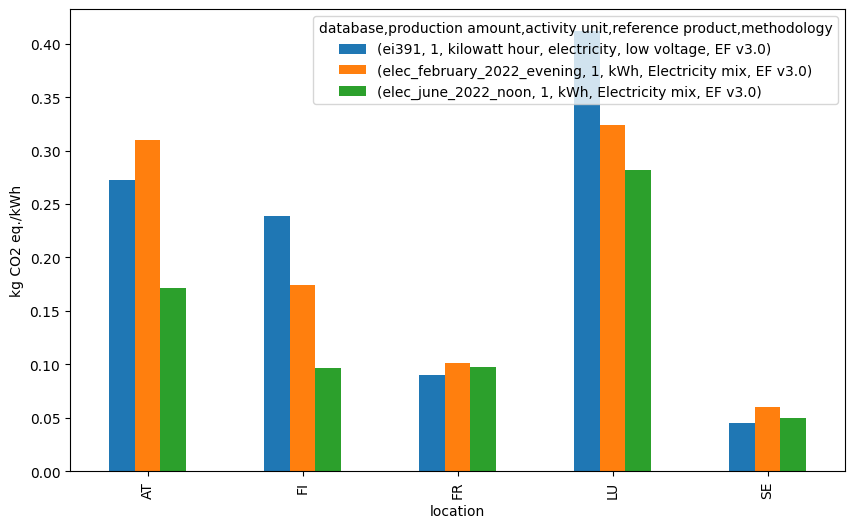

In [ ]:
ax = res_df[('score', 'climate change', 'global warming potential (GWP100)', 'kg CO2-Eq')].droplevel(['activity']).unstack(['location']).T.plot.bar(figsize=(10,6))
ax.set_ylabel('kg CO2 eq./kWh')

# Further analysis and comparisons

In [ ]:
m_lca.lci()

In [ ]:
m_lca.invert_technosphere_matrix()

array([[1.02260085e+00, 6.30951937e-06, 3.20314852e-06, ...,
        7.38898083e-08, 3.34581255e-07, 5.00226922e-08],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.93197965e-05, 2.54070633e-07, 1.00000026e+00, ...,
        5.28531010e-08, 1.28025970e-08, 2.63254374e-08],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
m_lca.demands

{'Electricity mix in AT, summer, noon': {31765: 1},
 'Electricity mix in FI, summer, noon': {31766: 1},
 'Electricity mix in SE, summer, noon': {31769: 1},
 'Electricity mix in LU, summer, noon': {31768: 1},
 'Electricity mix in FR, summer, noon': {31767: 1},
 'Electricity mix in AT, winter, evening': {31770: 1},
 'Electricity mix in LU, winter, evening': {31773: 1},
 'Electricity mix in SE, winter, evening': {31774: 1},
 'Electricity mix in FI, winter, evening': {31771: 1},
 'Electricity mix in FR, winter, evening': {31772: 1},
 'market for electricity, low voltage, AT': {8291: 1},
 'market for electricity, low voltage, FI': {7811: 1},
 'market for electricity, low voltage, FR': {8312: 1},
 'market for electricity, low voltage, LU': {18072: 1},
 'market for electricity, low voltage, SE': {22321: 1}}

In [ ]:
matrix_indices = [{k:m_lca.activity_dict[vk] for vk in v.keys()} for k,v in m_lca.demands.items()]
matrix_indices

[{'Electricity mix in AT, summer, noon': 21238},
 {'Electricity mix in FI, summer, noon': 21239},
 {'Electricity mix in SE, summer, noon': 21242},
 {'Electricity mix in LU, summer, noon': 21241},
 {'Electricity mix in FR, summer, noon': 21240},
 {'Electricity mix in AT, winter, evening': 21243},
 {'Electricity mix in LU, winter, evening': 21246},
 {'Electricity mix in SE, winter, evening': 21247},
 {'Electricity mix in FI, winter, evening': 21244},
 {'Electricity mix in FR, winter, evening': 21245},
 {'market for electricity, low voltage, AT': 3581},
 {'market for electricity, low voltage, FI': 3101},
 {'market for electricity, low voltage, FR': 3602},
 {'market for electricity, low voltage, LU': 13362},
 {'market for electricity, low voltage, SE': 17611}]

In [ ]:
m_lca.inverted_technosphere_matrix.shape

(21248, 21248)

In [ ]:
demands_inverted = {k:m_lca.inverted_technosphere_matrix[:,v] for d in matrix_indices for k,v in d.items()}

In [ ]:
reversed_activity_dict = {v:k for k,v in m_lca.activity_dict.items()}

In [ ]:
matrix_index = [bd.get_activity(reversed_activity_dict[i]) for i in range(m_lca.inverted_technosphere_matrix.shape[0])]

In [ ]:
properties = ['name', 'unit', 'code', 'location', 'reference product', 'type', 'database', 'id']
df_index = pd.MultiIndex.from_tuples([[m[prop] for prop in properties] for m in matrix_index], names=properties)

In [ ]:
demands_inverted_df = pd.DataFrame(demands_inverted, index=df_index)

In [ ]:
process_contribution = demands_inverted_df.sort_values(by=demands_inverted_df.columns[0], ascending=False)

In [ ]:
idx_elec = process_contribution.index.get_level_values('name').str.startswith('electricity production')

In [ ]:
process_contribution_elec = process_contribution.loc[idx_elec].sort_index(axis=1).droplevel(['unit','code','reference product','type','database','id'])
process_contribution_elec

Electricity mix in AT, summer, noon  \
name                                               location                                        
electricity production, hydro, run-of-river        AT                                   0.462168   
electricity production, hydro, reservoir, alpin... AT                                   0.074982   
electricity production, wind, 1-3MW turbine, on... AT                                   0.073703   
electricity production, nuclear, pressure water... CZ                                   0.039693   
electricity production, lignite                    CZ                                   0.035402   
...                                                                                          ...   
electricity production, wind, >3MW turbine, ons... CN-NX                                0.000000   
electricity production, hydro, reservoir, alpin... IN-KA                                0.000000   
                                                   IN-PB                                0.000000   
electricity production, photovoltaic, 3kWp faca... RoW                                  0.000000   
electricity production, wind, >3MW turbine, ons... IN-TN                                0.000000   

                                                             Electricity mix in AT, winter, evening  \
name                                               location                                           
electricity production, hydro, run-of-river        AT                                      0.249355   
electricity production, hydro, reservoir, alpin... AT                                      0.022491   
electricity production, wind, 1-3MW turbine, on... AT                                      0.133190   
electricity production, nuclear, pressure water... CZ                                      0.056537   
electricity production, lignite                    CZ                                      0.050990   
...                                                                                             ...   
electricity production, wind, >3MW turbine, ons... CN-NX                                   0.000000   
electricity production, hydro, reservoir, alpin... IN-KA                                   0.000000   
                                                   IN-PB                                   0.000000   
electricity production, photovoltaic, 3kWp faca... RoW                                     0.000000   
electricity production, wind, >3MW turbine, ons... IN-TN                                   0.000000   

                                                             Electricity mix in FI, summer, noon  \
name                                               location                                        
electricity production, hydro, run-of-river        AT                                   0.000061   
electricity production, hydro, reservoir, alpin... AT                                   0.000020   
electricity production, wind, 1-3MW turbine, on... AT                                   0.000014   
electricity production, nuclear, pressure water... CZ                                   0.000059   
electricity production, lignite                    CZ                                   0.000055   
...                                                                                          ...   
electricity production, wind, >3MW turbine, ons... CN-NX                                0.000000   
electricity production, hydro, reservoir, alpin... IN-KA                                0.000000   
                                                   IN-PB                                0.000000   
electricity production, photovoltaic, 3kWp faca... RoW                                  0.000000   
electricity production, wind, >3MW turbine, ons... IN-TN                                0.000000   

                                                             Electricity mix in FI, winter, evening  \
name            

In [ ]:
country = 'LU'
threshold = 0.05



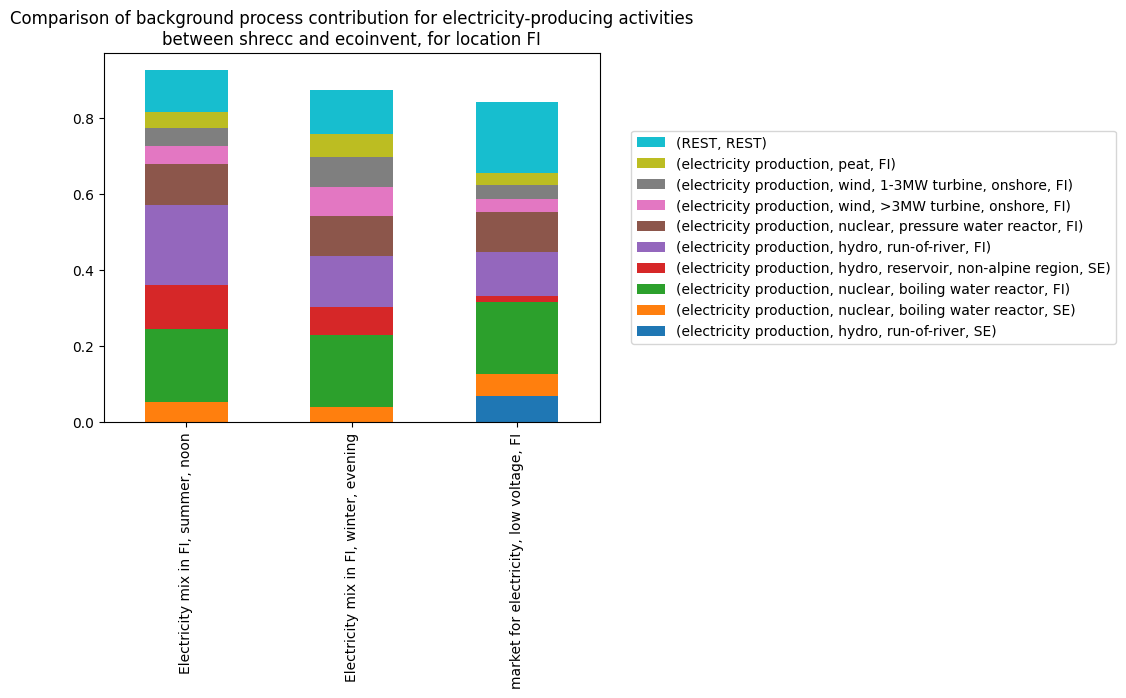

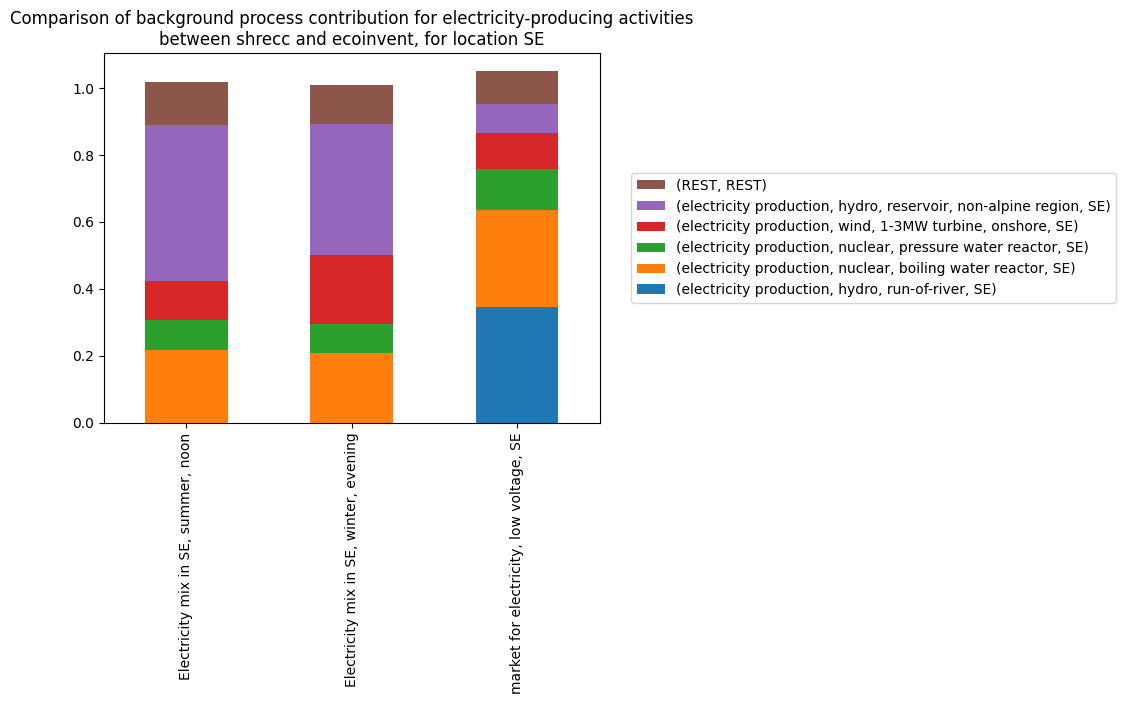

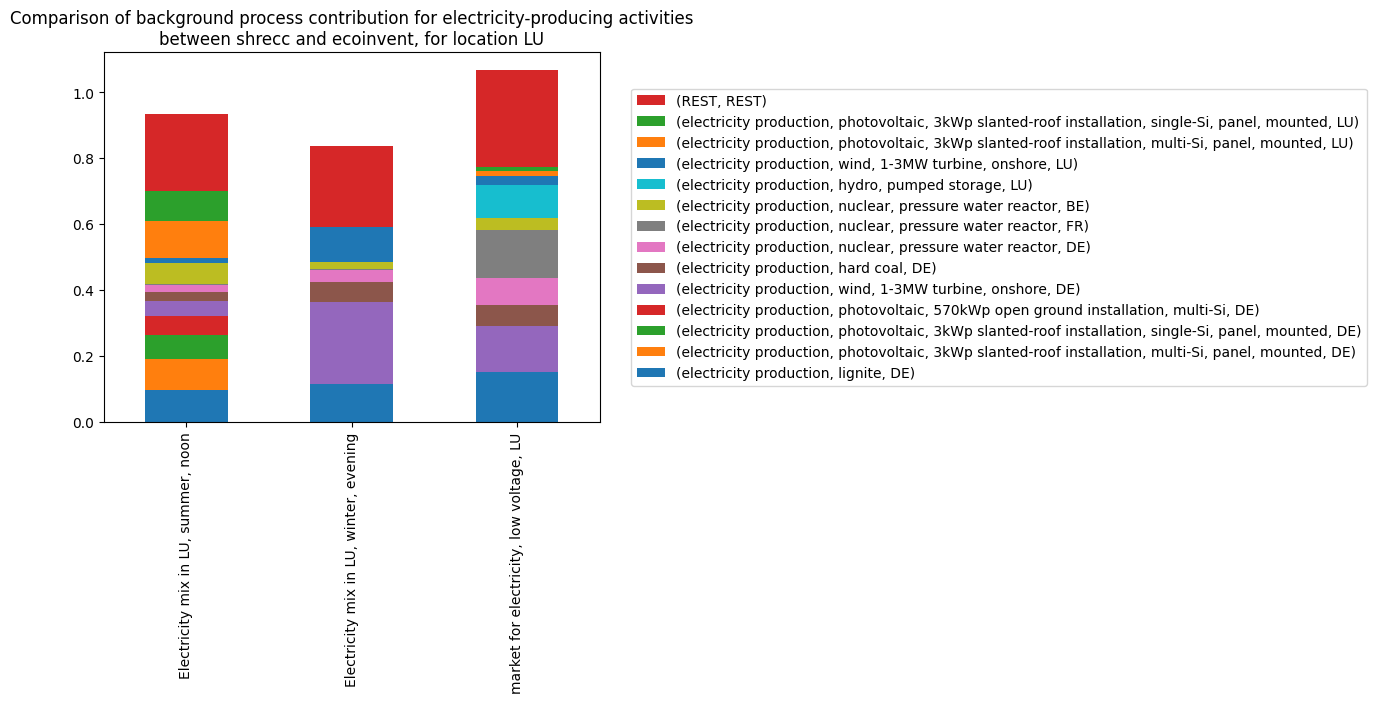

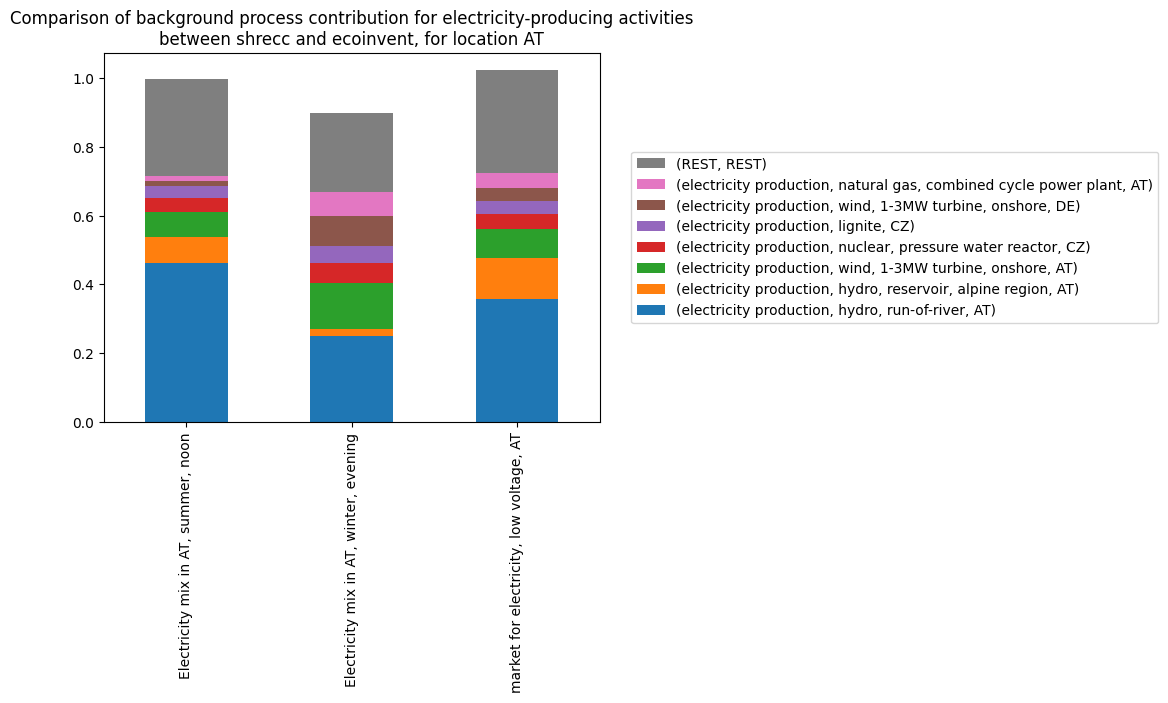

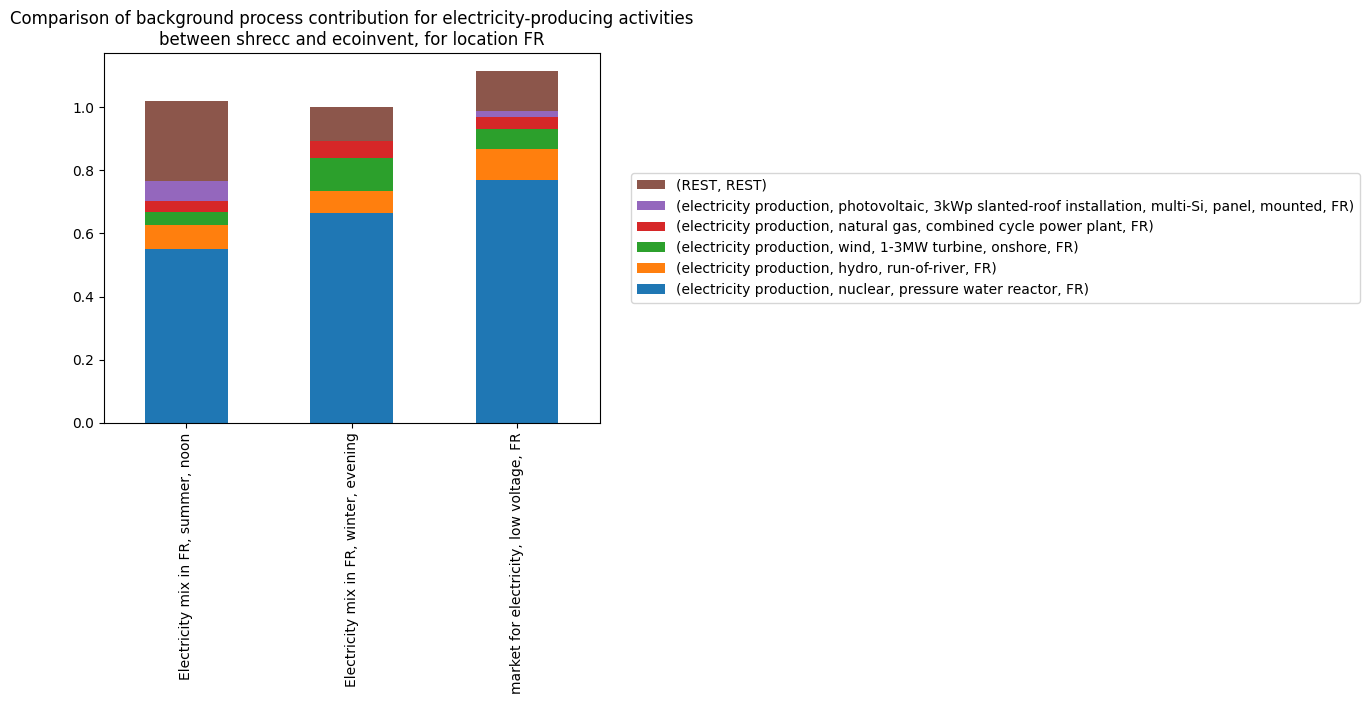

In [ ]:
for country in countries:
    process_contribution_elec_c = process_contribution_elec[[c for c in process_contribution_elec if country in c]]

    idx_filt = (process_contribution_elec_c >= threshold).any(axis=1)
    mix_to_plot = pd.concat([process_contribution_elec_c.loc[idx_filt],
            pd.DataFrame(process_contribution_elec_c[~idx_filt].sum(), columns=[('REST', 'REST')]).T],
            axis=0).T#.droplevel(['code','unit'], axis=0)

    ax = mix_to_plot.plot.bar(stacked=True)
    h,l = ax.get_legend_handles_labels()
    ax.legend(loc='center left', bbox_to_anchor=(1.05,0.5), handles=h[::-1], labels=l[::-1])
    ax.set_title(f'Comparison of background process contribution for electricity-producing activities\nbetween shrecc and ecoinvent, for location {country}')


Some remarks about the mix analysis.

1. From the comparison of background processes in Sweden, you can see that the electricity mix done by shrecc contains some aggregated data for hydro electricity. On the Energy Chart API, there is no distinction between the types, and so all hydro (run-off-river, reservoir, hydro pumped storage) is together in one category. Ecoinvent has the different types in the mix.
2. Not all background processes sum to one; we performed our search based on "electricity production", and there might be some activities with a different name, still contributing to the electricity mix.